# Chapter 7 — LoRA Fine-tuning Theory: Adapting VieNeu-TTS to Your Voice

In [1]:
# ── Colab auto-setup (safe to run locally too) ───────────────────
import sys, os

if "google.colab" in sys.modules:
    if not os.path.exists("/content/vietnamese-tts-course"):
        !git clone https://github.com/thinhdanggroup/vietnamese-tts-course.git /content/vietnamese-tts-course
    os.chdir("/content/vietnamese-tts-course/chapters")
    !pip install -q librosa soundfile matplotlib

    if not os.path.exists("/content/VieNeu-TTS"):
        !git clone https://github.com/pnnbao97/VieNeu-TTS.git /content/VieNeu-TTS
        !pip install -q -e /content/VieNeu-TTS
    sys.path.insert(0, "/content/VieNeu-TTS")
    print("Colab setup complete.")

Colab setup complete.


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
import os

## 1. Memory Cost of Fine-tuning — Why We Need LoRA

In [3]:
def estimate_finetune_memory(num_params_M, dtype_bytes=4, batch_size=2,
                              seq_len=2048, hidden_dim=1024, num_layers=24):
    weights_GB = num_params_M * 1e6 * dtype_bytes / 1e9
    gradients_GB = weights_GB
    adam_states_GB = 2 * weights_GB
    activation_GB = (batch_size * seq_len * hidden_dim * num_layers * dtype_bytes) / 1e9
    total_GB = weights_GB + gradients_GB + adam_states_GB + activation_GB
    return {
        "weights": weights_GB,
        "gradients": gradients_GB,
        "adam_states": adam_states_GB,
        "activations": activation_GB,
        "total": total_GB
    }

mem = estimate_finetune_memory(300)
print("=== Full Fine-tuning Memory Estimate (VieNeu-TTS-0.3B) ===")
for k, v in mem.items():
    print(f"  {k:15s}: {v:.2f} GB")
print(f"\nRequired GPU VRAM: >{mem['total']:.0f} GB")
print(f"RTX 3090 (24 GB): {'OK' if mem['total'] < 24 else 'OOM'}")
print(f"RTX 3060 (12 GB): {'OK' if mem['total'] < 12 else 'OOM'}")

=== Full Fine-tuning Memory Estimate (VieNeu-TTS-0.3B) ===
  weights        : 1.20 GB
  gradients      : 1.20 GB
  adam_states    : 2.40 GB
  activations    : 0.40 GB
  total          : 5.20 GB

Required GPU VRAM: >5 GB
RTX 3090 (24 GB): OK
RTX 3060 (12 GB): OK


## 2. LoRA: Low-Rank Approximation — The Math

For a weight matrix $W \in \mathbb{R}^{d \times k}$, LoRA represents the update as:
$$\Delta W = BA, \quad B \in \mathbb{R}^{d \times r},\ A \in \mathbb{R}^{r \times k}, \quad r \ll \min(d, k)$$

The full forward pass becomes:
$$h = (W + \frac{\alpha}{r} BA)x$$

r=  1: params=   128 (3.1%), error=0.0000
r=  2: params=   256 (6.2%), error=0.0000
r=  4: params=   512 (12.5%), error=0.0000
r=  8: params=  1024 (25.0%), error=0.0000
r= 16: params=  2048 (50.0%), error=0.0000
r= 32: params=  4096 (100.0%), error=0.0000
r= 64: params=  8192 (200.0%), error=0.0000


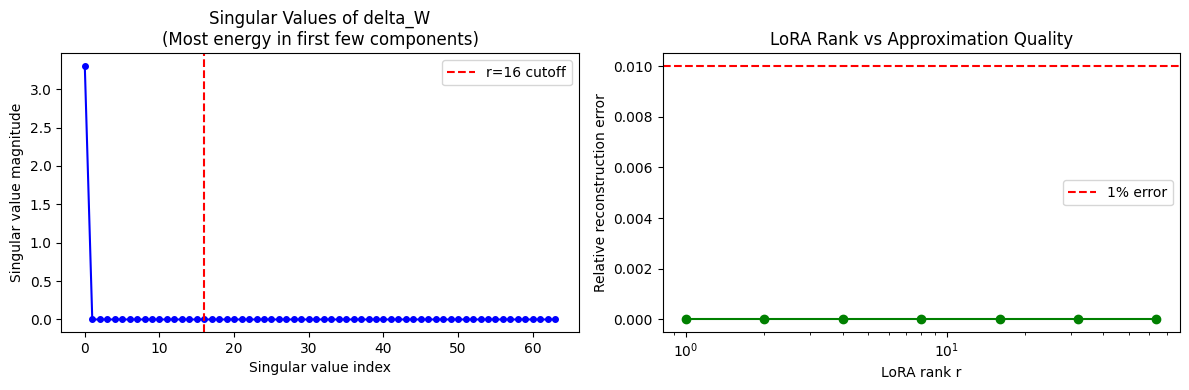

In [4]:
np.random.seed(42)
d, k = 64, 64
W = np.random.randn(d, k) * 0.1
W_finetuned = W + np.outer(np.random.randn(d), np.random.randn(k)) * 0.05
delta_W = W_finetuned - W
U, sigma, Vt = np.linalg.svd(delta_W)

fig, axes = plt.subplots(1, 2, figsize=(12, 4))
axes[0].plot(sigma, 'b-o', markersize=4)
axes[0].axvline(x=16, color='r', linestyle='--', label='r=16 cutoff')
axes[0].set_xlabel("Singular value index")
axes[0].set_ylabel("Singular value magnitude")
axes[0].set_title("Singular Values of delta_W\n(Most energy in first few components)")
axes[0].legend()

r_values = [1, 2, 4, 8, 16, 32, 64]
errors = []
for r in r_values:
    approx = U[:, :r] @ np.diag(sigma[:r]) @ Vt[:r, :]
    err = np.linalg.norm(delta_W - approx, 'fro') / np.linalg.norm(delta_W, 'fro')
    errors.append(err)
    print(f"r={r:3d}: params={d*r + r*k:6d} ({(d*r+r*k)/(d*k)*100:.1f}%), error={err:.4f}")

axes[1].semilogx(r_values, errors, 'g-o')
axes[1].set_xlabel("LoRA rank r")
axes[1].set_ylabel("Relative reconstruction error")
axes[1].set_title("LoRA Rank vs Approximation Quality")
axes[1].axhline(y=0.01, color='r', linestyle='--', label='1% error')
axes[1].legend()
plt.tight_layout()
plt.show()

## 3. Parameter Count: LoRA vs Full Fine-tuning

In [5]:
def lora_params(d, k, r): return d * r + r * k
def full_params(d, k): return d * k

layers = {
    "q_proj (1024x1024)": (1024, 1024),
    "k_proj (1024x1024)": (1024, 1024),
    "v_proj (1024x1024)": (1024, 1024),
    "o_proj (1024x1024)": (1024, 1024),
    "gate_proj (1024x4096)": (1024, 4096),
    "up_proj (1024x4096)": (1024, 4096),
    "down_proj (4096x1024)": (4096, 1024),
}
r = 16
num_layers = 24
rows = []
for name, (d, k) in layers.items():
    full = full_params(d, k)
    lora = lora_params(d, k, r)
    rows.append({"Layer": name, "Full params": full,
                 "LoRA params (r=16)": lora, "Savings": f"{full//lora}x"})
df = pd.DataFrame(rows)
print(df.to_string())
total_lora = sum(lora_params(d,k,r) * num_layers for d,k in layers.values())
total_full = sum(full_params(d,k) * num_layers for d,k in layers.values())
print(f"\nTotal LoRA trainable: {total_lora:,}")
print(f"Total full finetune:  {total_full:,}")
print(f"LoRA ratio: {total_lora/total_full*100:.1f}%")

                   Layer  Full params  LoRA params (r=16) Savings
0     q_proj (1024x1024)      1048576               32768     32x
1     k_proj (1024x1024)      1048576               32768     32x
2     v_proj (1024x1024)      1048576               32768     32x
3     o_proj (1024x1024)      1048576               32768     32x
4  gate_proj (1024x4096)      4194304               81920     51x
5    up_proj (1024x4096)      4194304               81920     51x
6  down_proj (4096x1024)      4194304               81920     51x

Total LoRA trainable: 9,043,968
Total full finetune:  402,653,184
LoRA ratio: 2.2%


## 4. LoRA Memory Savings

In [6]:
def lora_memory_GB(trainable_params_M):
    base = 300 * 1e6 * 2 / 1e9  # frozen model fp16
    lora = trainable_params_M * 1e6 * 4 / 1e9
    overhead = lora + lora + 2 * lora  # weights + grad + adam
    return base + overhead, base, overhead

total, base, overhead = lora_memory_GB(4)
print("=== LoRA Memory Estimate ===")
print(f"  Frozen base (fp16): {base:.2f} GB")
print(f"  LoRA overhead:      {overhead:.2f} GB")
print(f"  Total:              {total:.2f} GB")
print(f"\n  RTX 3060 (12 GB): {'OK' if total < 12 else 'OOM'}")
print(f"  RTX 3090 (24 GB): OK")

=== LoRA Memory Estimate ===
  Frozen base (fp16): 0.60 GB
  LoRA overhead:      0.06 GB
  Total:              0.66 GB

  RTX 3060 (12 GB): OK
  RTX 3090 (24 GB): OK


## 5. Rank Sensitivity — Choosing r

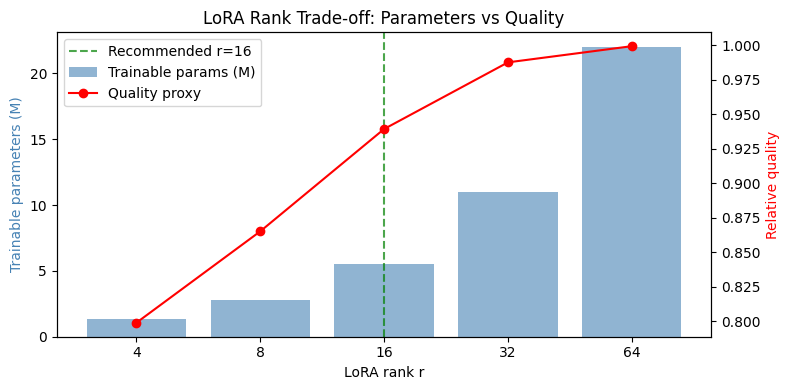

r=  4: 1.4M params, quality=0.799
r=  8: 2.8M params, quality=0.865
r= 16: 5.5M params, quality=0.939
r= 32: 11.0M params, quality=0.988
r= 64: 22.0M params, quality=1.000


In [7]:
r_vals = [4, 8, 16, 32, 64]
d, k = 1024, 1024
num_layers = 24
modules_per_layer = 7

params = [lora_params(d, k, r) * num_layers * modules_per_layer for r in r_vals]
quality_proxy = [1 - 0.3 * np.exp(-r / 10) for r in r_vals]

fig, ax1 = plt.subplots(figsize=(8, 4))
ax2 = ax1.twinx()
ax1.bar([str(r) for r in r_vals], [p/1e6 for p in params], alpha=0.6, color='steelblue', label='Trainable params (M)')
ax2.plot([str(r) for r in r_vals], quality_proxy, 'ro-', label='Quality proxy')
ax1.set_xlabel("LoRA rank r")
ax1.set_ylabel("Trainable parameters (M)", color='steelblue')
ax2.set_ylabel("Relative quality", color='red')
ax1.set_title("LoRA Rank Trade-off: Parameters vs Quality")
ax1.axvline(x=2, color='green', linestyle='--', alpha=0.7, label='Recommended r=16')
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left')
plt.tight_layout()
plt.show()

for r, p, q in zip(r_vals, params, quality_proxy):
    print(f"r={r:3d}: {p/1e6:.1f}M params, quality={q:.3f}")

## 6. LoRA Hyperparameter Cheat Sheet for VieNeu-TTS

| Parameter | Value | Notes |
|-----------|-------|-------|
| `r` | 16 | Rank — good balance for single voice |
| `lora_alpha` | 32 | Always 2× rank |
| `lora_dropout` | 0.05 | Light regularization |
| `target_modules` | q/k/v/o + MLP | All attention + feed-forward |
| `learning_rate` | 2e-4 | Higher than full fine-tune |
| `max_steps` | 5000 | For ~1000 clips |
| `batch_size` | 2 | Reduce to 1 if OOM |
| `warmup_ratio` | 0.05 | First 5% of steps |